In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import clean_data
import random

init_cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
              'MEAN_MOTION', 'NORAD_CAT_ID', 'EPOCH',
             ]


def load_raw(name=None):
    if not name:
        train_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/train.pkl' ) # Time: 25.7s
        test_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/test.pkl' ) # Time: 5
        return {'train': train_df, 'test': test_df}
    elif name == 'train':
        return {name: pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/train.pkl' )}
    elif name == 'test':
        return {name: pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/test.pkl' )}

def truncate_data(df, perc):
    norad_count = int(len(df.NORAD_CAT_ID.unique()) * perc)
    df=df[df['INCLINATION'].between(0,180) &
          df['RA_OF_ASC_NODE'].between(0,360) &
          df['ECCENTRICITY'].between(0,0.25) &
          df['ARG_OF_PERICENTER'].between(0,360) &
          df['MEAN_ANOMALY'].between(0,360) &
          df['MEAN_MOTION'].between(11.25,17) &
          (df.EPOCH >= '1990-01-01') &
          (df.NORAD_CAT_ID.isin(df.NORAD_CAT_ID.unique()[:norad_count]))].reset_index(drop=True)
    return df

def create_save(perc, name=None):
    print('>>> Loading raw data')
    df_in = load_raw(name)

    df_out = []
    for name, df in df_in.items():
        print(f'>>> Truncating {name} data...')
        df = truncate_data(df, perc) # 14.5s
        df = df[init_cols]  # 4s

        print(f'>>> Normalizing {name} data...')
        df = clean_data.normalize_all_columns(df) # 53.4s

        print(f'>>> Building {name} index map...')
        idx_map = clean_data.create_index_map(df, threaded=True, batch_size=50) # 3min 29s

        print(f'>>> Building {name} inputs and labels')
        X,y = clean_data.build_xy(df, idx_map) # 59min 41s
        X = clean_data.normalize_epoch_diff(X, drop_epoch=False) # 19s

        print(f'>>> Saving {name} data')
        X.to_pickle(os.environ['GP_HIST_PATH'] + f'/cleaned/x_{name}1.pkl')
        y.to_pickle(os.environ['GP_HIST_PATH'] + f'/cleaned/y_{name}1.pkl')
        df_out.extend([X,y])
    
    return df_out

def load(perc, force_update=False):
    if not force_update:
        print('>>> Loading data')
        
        X_train = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/cleaned/x_train1.pkl')
        y_train = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/cleaned/y_train1.pkl')
        X_test = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/cleaned/x_test1.pkl')
        y_test = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/cleaned/y_test1.pkl')
        return X_train, y_train, X_test, y_test
    else:
        return create_save(perc)
        

perc = 0.05
force_update = False

X_train, y_train, X_test, y_test = load(perc, force_update)
print(f'>>> Complete')

>>> Loading data
>>> Complete


In [2]:
pd.set_option('display.max_columns', 999)

# Train on only 2 rows:
X_train = X_train.iloc[0:2]
y_train = y_train.iloc[0:2]

print(f'Train: rows={len(X_train)}')
display(X_train.head())
display(y_train.head())


print(f'Test: rows={len(X_test)}')
display(X_test.head())
display(y_test.head())

Train: rows=2


,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,year,month_sin,month_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,ms_sin,ms_cos,year_y,month_sin_y,month_cos_y,hour_sin_y,hour_cos_y,minute_sin_y,minute_cos_y,second_sin_y,second_cos_y,ms_sin_y,ms_cos_y,EPOCH,EPOCH_y,epoch_day_diff,epoch_sec_diff,epoch_ms_diff
0,0.0001,0.409839,0.998673,0.028386,0.905370,0.093658,0.195972,0.516129,1.0,6.123234e-17,-1.0,-1.836970e-16,0.951057,-0.309017,-0.978148,-0.207912,-0.965432,-0.260653,0.322581,0.000000,1.0,-1.000000,-1.836970e-16,0.500000,0.866025,-0.951057,0.309017,0.992961,-0.118442,2006-04-18 18:18:43.708031,2000-01-24 18:05:48.268895,0.199352,0.008970,0.439136
1,0.0001,0.409945,0.337814,0.028308,0.007366,0.993029,0.195022,0.322581,0.0,1.000000e+00,-1.0,-1.836970e-16,0.500000,0.866025,-0.951057,0.309017,0.992961,-0.118442,0.516129,0.866025,0.5,0.866025,-5.000000e-01,0.309017,0.951057,0.978148,-0.207912,0.311788,0.950152,2000-01-24 18:05:48.268895,2006-03-31 08:03:17.050464,-0.197775,0.418414,0.218431


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.409945,0.337814,0.028308,0.007366,0.993029,0.195022
1,0.409834,0.066217,0.028058,0.978702,0.021288,0.195969


Test: rows=1851689


,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,year,month_sin,month_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,ms_sin,ms_cos,year_y,month_sin_y,month_cos_y,hour_sin_y,hour_cos_y,minute_sin_y,minute_cos_y,second_sin_y,second_cos_y,ms_sin_y,ms_cos_y,EPOCH,EPOCH_y,epoch_day_diff,epoch_sec_diff,epoch_ms_diff
0,0.000377,0.411331,0.811906,0.008346,0.661089,0.338674,0.528211,0.096774,0.866025,0.500000,-0.866025,-5.000000e-01,-0.743145,-0.669131,-0.406737,-0.913545,-0.879241,-0.476376,0.935484,-0.866025,-0.500000,-0.866025,5.000000e-01,0.104528,0.994522,-0.587785,0.809017,-0.279522,0.960139,1993-03-16 16:38:34.670975,2019-09-08 20:01:54.954912,-0.847245,0.858785,0.716063
1,0.000048,0.411293,0.458819,0.007412,0.760359,0.395787,0.552408,0.935484,-0.866025,-0.500000,-0.866025,5.000000e-01,0.104528,0.994522,-0.587785,0.809017,-0.279522,0.960139,0.483871,0.866025,-0.500000,1.000000,6.123234e-17,-0.587785,-0.809017,-0.309017,-0.951057,-0.931649,-0.363359,2019-09-08 20:01:54.954912,2005-05-27 06:36:33.690815,0.456950,0.559271,0.264097
2,0.000150,0.411304,0.241542,0.006994,0.090706,0.909914,0.543893,0.483871,0.866025,-0.500000,1.000000,6.123234e-17,-0.587785,-0.809017,-0.309017,-0.951057,-0.931649,-0.363359,0.709677,0.000000,1.000000,-0.866025,5.000000e-01,-0.951057,0.309017,0.309017,-0.951057,-0.799398,-0.600802,2005-05-27 06:36:33.690815,2012-01-14 20:48:27.647424,-0.212315,0.408403,0.043391
3,0.000153,0.411298,0.834299,0.006761,0.030208,0.970194,0.546404,0.709677,0.000000,1.000000,-0.866025,5.000000e-01,-0.951057,0.309017,0.309017,-0.951057,-0.799398,-0.600802,0.903226,0.500000,-0.866025,-0.965926,2.588190e-01,-0.809017,0.587785,0.978148,0.207912,-0.156981,0.987602,2012-01-14 20:48:27.647424,2018-06-06 19:51:13.974912,-0.204520,0.039734,0.672512
4,0.000061,0.411287,0.825043,0.006812,0.445791,0.972837,0.552108,0.903226,0.500000,-0.866025,-0.965926,2.588190e-01,-0.809017,0.587785,0.978148,0.207912,-0.156981,0.987602,0.580645,0.500000,-0.866025,0.258819,-9.659258e-01,0.669131,-0.743145,-0.309017,0.951057,-0.629880,-0.776692,2018-06-06 19:51:13.974912,2008-06-19 11:23:57.608448,0.318735,0.352269,0.366464


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.411293,0.458819,0.007412,0.760359,0.395787,0.552408
1,0.411304,0.241542,0.006994,0.090706,0.909914,0.543893
2,0.411298,0.834299,0.006761,0.030208,0.970194,0.546404
3,0.411287,0.825043,0.006812,0.445791,0.972837,0.552108
4,0.411279,0.514655,0.007800,0.612954,0.386987,0.544837


In [7]:
%%time
import train

cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY',
       'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'year', 'month_sin',
       'month_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
       'second_sin', 'second_cos', 'ms_sin', 'ms_cos', 'year_y', 'month_sin_y',
       'month_cos_y', 'hour_sin_y', 'hour_cos_y', 'minute_sin_y',
       'minute_cos_y', 'second_sin_y', 'second_cos_y', 'ms_sin_y', 'ms_cos_y',
       'epoch_day_diff', 'epoch_sec_diff', 'epoch_ms_diff']

model = train.create_model(len(cols), len(y_train.columns),
                           layer1=50, relu1=True, #drop1=0.2,
                           layer2=30, relu2=True, #drop2=0.2,
                           layer3=30, relu3=True, #drop3=0.2,
                           layer4=30, relu4=True, #drop4=0.5,
                           layer5=20, relu5=True, #drop5=0.5,
                           layer6=20, relu6=True, #drop6=0.5,
                           layer7=20, relu7=True, #drop7=0.5,
                           layer8=10, relu8=True, #drop8=0.5,
                           layer9=10, relu9=True, #drop9=0.5,
                          )
display(model)

device='cuda'

# # Train on 5%
# trained_model, loss_output = train.train_model(X_train[cols], y_train, model=model, batch_size=2000,
#                                                learning_rate=0.01, num_epochs=10, 
#                                                device=device, num_workers=5, loss='L2' )

# Train on only 2 rows:
trained_model, loss_output = train.train_model(X_train[cols], y_train, model=model, batch_size=2,
                                               learning_rate=0.001, num_epochs=200, 
                                               device=device, num_workers=5, loss='L2' )

NNModelEx(
  (net): Sequential(
    (0): Linear(in_features=32, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
    (8): Linear(in_features=30, out_features=20, bias=True)
    (9): ReLU()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): ReLU()
    (14): Linear(in_features=20, out_features=10, bias=True)
    (15): ReLU()
    (16): Linear(in_features=10, out_features=10, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10, out_features=6, bias=True)
  )
)

batch_size=2 learning_rate=0.001
>>> Loading dataset
>>> Beginning training!


  0%|          | 0/200 [00:00<?, ?it/s]

Final loss: 0.11392825841903687
Wall time: 2min 22s


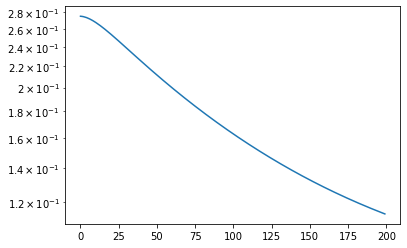

In [8]:
plt.plot([float(l['loss']) for l in loss_output])
plt.yscale('log')

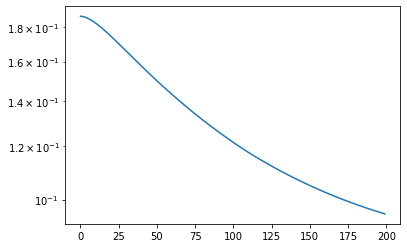

In [6]:
plt.plot([float(l['loss']) for l in loss_output])
plt.yscale('log')

In [5]:
y_train_pred = train.predict(trained_model, X_train[cols], y_train, device=device) # get predictions for each train
y_train_pred_df = pd.DataFrame(y_train_pred, columns=y_train.columns)  # put results into a dataframe
# y_test_pred = train.predict(trained_model, X_test[cols], y_test, device=device) # get predictions for each train
# y_test_pred_df = pd.DataFrame(y_test_pred, columns=y_test.columns)  # put results into a dataframe

# print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_test, y_test_pred_df)}')
# print(f'    Test set MSE (L2) loss: {mean_squared_error(y_test, y_test_pred_df)}')

random.seed(0)
#sample = random.sample(list(y_train_pred_df.index), 5)
sample = [0,1]

print("Train - Ground Truth (normalized):")
display(y_train.loc[sample])
print("Train - Ground Truth (non-normalized):")
display(clean_data.normalize_all_columns(y_train.loc[sample].copy(), reverse=True))  # see ground truths
print("Train - Prediction (normalized):")
display(y_train_pred_df.loc[sample])
print("Train - Prediction (non-normalized):")
display(clean_data.normalize_all_columns(y_train_pred_df.loc[sample].copy(), reverse=True))  # See predictions

Train - Ground Truth (normalized):


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.409945,0.337814,0.028308,0.007366,0.993029,0.195022
1,0.409834,0.066217,0.028058,0.978702,0.021288,0.195969


Train - Ground Truth (non-normalized):


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,73.7901,121.6130,0.007077,2.6519,357.4904,12.371379
1,73.7702,23.8382,0.007014,352.3327,7.6638,12.376819


Train - Prediction (normalized):


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.390353,0.502573,0.043550,0.511284,0.489672,0.188558
1,0.404765,0.442349,-0.008086,0.510722,0.488479,0.211366


Train - Prediction (non-normalized):


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,70.263496,180.926407,0.010887,184.062363,176.281982,12.334208
1,72.857666,159.245514,-0.002022,183.860016,175.852554,12.465356


In [19]:
def row_to_compare(X, y, y_pred, row):
    epoch = X.iloc[row].EPOCH_y
    X0 = clean_data.normalize_all_columns(X_train.iloc[row].copy(), reverse=True)
    y0 = clean_data.normalize_all_columns(y_train.iloc[row].copy(), reverse=True)
    y1 = clean_data.normalize_all_columns(y_train_pred_df.iloc[row].copy(), reverse=True)

    # Ground truth
    y0_xyz = clean_data.get_satellite_xyz(bst=0.0001,
                                          ecc=y0.ECCENTRICITY,
                                          aop=y0.ARG_OF_PERICENTER,
                                          inc=y0.INCLINATION,
                                          mea=y0.MEAN_ANOMALY,
                                          mem=y0.MEAN_MOTION,
                                          raa=y0.RA_OF_ASC_NODE,
                                          epoch=epoch,)
    # Prediction
    y1_xyz = clean_data.get_satellite_xyz(bst=0.0001,
                                          ecc=y1.ECCENTRICITY,
                                          aop=y1.ARG_OF_PERICENTER,
                                          inc=y1.INCLINATION,
                                          mea=y1.MEAN_ANOMALY,
                                          mem=y1.MEAN_MOTION,
                                          raa=y1.RA_OF_ASC_NODE,
                                          epoch=epoch,)
    # Propigation
    y2_xyz = clean_data.get_satellite_xyz(bst=X0.BSTAR,
                                          ecc=X0.ECCENTRICITY,
                                          aop=X0.ARG_OF_PERICENTER,
                                          inc=X0.INCLINATION,
                                          mea=X0.MEAN_ANOMALY,
                                          mem=X0.MEAN_MOTION,
                                          raa=X0.RA_OF_ASC_NODE,
                                          epoch=epoch,)
    print(f'Ground Truth: {y0_xyz}')
    print(f'Predicted: {y1_xyz}')
    print(f'Propigation: {y2_xyz}')
    
    print (f'Prediction Error: {sum((y1_xyz-y0_xyz)**2)**0.5} km')
    print (f'Propigation Error: {sum((y2_xyz-y0_xyz)**2)**0.5} km')
    

for row in range(2):
    print (f'Row {row}:')
    row_to_compare(X_train, y_train, y_train_pred_df, row)
    print('')

Row 0:
Ground Truth: [-4.11141422e+03  6.67947009e+03  2.55887754e-01]
Predicted: [-4.11066867e+03  6.67993360e+03 -7.11411195e-01]
Propigation: [ 7.85016858e+03 -6.54560438e+01  3.25070548e-02]
Prediction Error: 1.30627429652818 km
Propigation Error: 13732.206362207282 km

Row 1:
Ground Truth: [7.17304819e+03 3.16940935e+03 1.18593311e-02]
Predicted: [ 7.17312896e+03  3.16922246e+03 -7.80126081e-01]
Propigation: [-4.11141422e+03  6.67947009e+03  2.55887198e-01]
Prediction Error: 0.8177376661757888 km
Propigation Error: 11817.767056373674 km

